## Introduction

The Quantum Generative Adversarial Network (QGAN) [[1]](https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-machine-learning/qgan.ipynb)  [[2]](https://arxiv.org/abs/1406.2661) we propose consists of two Quantum Neural Network (QNN) [[3]](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/01_neural_networks.html): a generator and a discriminator. The generator is responsible for creating synthetic data samples. The discriminator evaluates the authenticity of the created samples by distinguishing between real and generated data. Through an adversarial training process, both networks continuously improve, leading to the generation of increasingly realistic data. 
This fully quantum approach benefits from the strengths of quantum state preparation and gradient calculation combined with classical optimizators [[4]](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).
The data used to train the QGAN in this implementation is a probability distributions.

This implementation uses aer_simulator_statevector.

## Implementation (statevector simulation)

In [218]:
# INSTALATION INSTRUCTIONS

# For linux 64-bit systems,
#uname -a

# Conda quick installation
#mkdir -p ~/miniconda3
#wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O ~/miniconda3/miniconda.sh
#bash ~/miniconda3/miniconda.sh -b -u -p ~/miniconda3
#rm ~/miniconda3/miniconda.sh

# Create enviroment with conda
#conda create -n myenv python=3.10
#conda activate myenv
#pip install qiskit==1.4.3 qiskit-machine-learning==0.8.2 'qiskit-machine-learning[sparse]' torch matplotlib pylatexenc ipykernel
# IMPORTANT: Make sure you are on 3.10
# May need to restart the kernel after instalation

In [219]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import random_statevector, Statevector, SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram

from qiskit_machine_learning.neural_networks import SamplerQNN # Downgrade to qiskit 1.x so is compatible with qiskit-machine-learning 0.8.2
from qiskit_machine_learning.gradients import ParamShiftSamplerGradient
from qiskit_machine_learning.utils import algorithm_globals

import numpy as np
import torch
from torch import nn
from qiskit_machine_learning.connectors import TorchConnector
import copy
import matplotlib.pyplot as plt
import time
import os
import random

In [220]:
# Number of qubits ## 4:4, 8:, 16:
N_QUBITS = 4

SEED = 4
np.random.seed(SEED)
algorithm_globals.random_seed = SEED
torch.manual_seed(SEED)
random.seed(42)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

draw_circuits = 1
draw_prob = 1
print_progress = 1

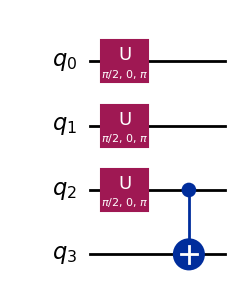

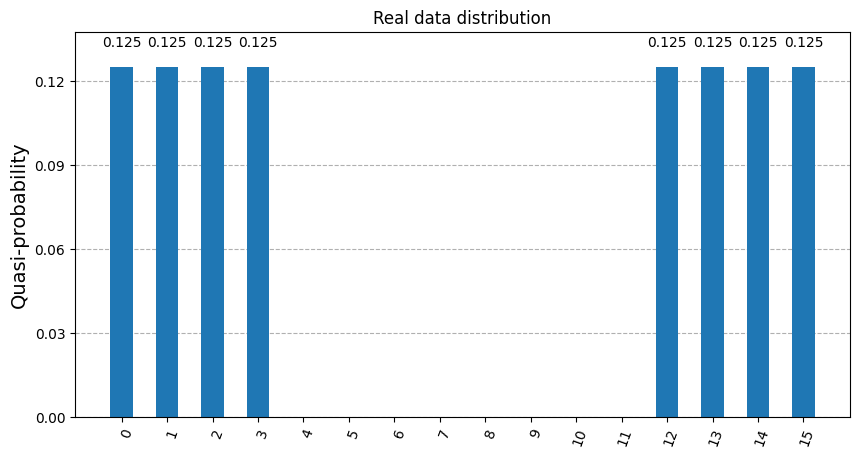

In [221]:
# Create real data sample circuit
def generate_real_circuit():
    # sv = random_statevector(2**N_QUBITS, seed=SEED)
    # qc = QuantumCircuit(N_QUBITS)
    # qc.prepare_state(sv, qc.qubits, normalize=True)

    qc = QuantumCircuit(N_QUBITS)
    qc.h(range(N_QUBITS-1))
    qc.cx(N_QUBITS-2, N_QUBITS-1)
    return qc


real_circuit = generate_real_circuit()

real_prob_dist = Statevector(real_circuit).probabilities()
real_dist = torch.tensor(real_prob_dist, dtype=torch.float).detach()
real_prob_dict = Statevector(real_circuit).probabilities_dict()

def prepare_dicts(dicts):
    for dict in dicts:
        for n in range(2**N_QUBITS):
            key = format(n, 'b').zfill(N_QUBITS)
            if key not in dict.keys():
                dict[n] = 0.0
            else:
                dict[n] = dict[key]
                del dict[key]

prepare_dicts([real_prob_dict])


if draw_circuits:
    display(real_circuit.decompose(reps=5).draw('mpl'))

if draw_prob:
    def prepare_dicts(dicts):
        for dict in dicts:
            for n in range(2**N_QUBITS):
                key = format(n, 'b').zfill(N_QUBITS)
                if key not in dict.keys():
                    dict[key] = 0.0

    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
    ax1.set_title("Real data distribution")
    plot_histogram(real_prob_dict, ax=ax1)

12


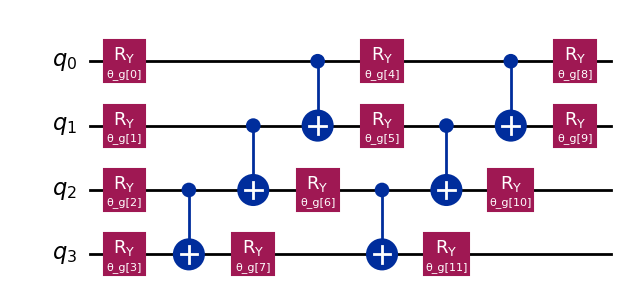

In [222]:
# Create generator circuit
def generate_generator_circuit():
    qc = RealAmplitudes(N_QUBITS,
                        reps=2, # Number of layers
                        parameter_prefix='θ_g',
                        name='Generator')
    return qc


generator_circuit = generate_generator_circuit()

N_GPARAMS = generator_circuit.num_parameters
print(N_GPARAMS)


if draw_circuits:
    display(generator_circuit.decompose().draw('mpl'))

{0: 0.1640625, 1: 0.0380859375, 2: 0.0166015625, 3: 0.017578125, 4: 0.1611328125, 5: 0.298828125, 6: 0.0, 7: 0.052734375, 8: 0.037109375, 9: 0.02734375, 10: 0.005859375, 11: 0.01171875, 12: 0.02734375, 13: 0.05078125, 14: 0.0166015625, 15: 0.07421875}


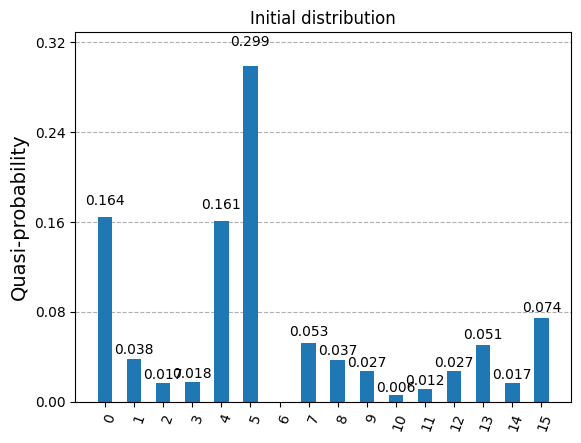

In [223]:
# Create generator and initialize parameters
def generate_generator(generator_circuit, sampler, gradient) -> TorchConnector:
    qnn = SamplerQNN(
        circuit=generator_circuit,
        input_params=[],
        weight_params=generator_circuit.parameters,
        sampler=sampler,
        gradient=gradient,
        sparse=False,
        input_gradients=True
    )

    initial_weights = algorithm_globals.random.random(generator_circuit.num_parameters)
    return TorchConnector(qnn, initial_weights)

def list_to_dict(l):
    return {index: value for index, value in enumerate(l)}

sampler = StatevectorSampler()
gradient = ParamShiftSamplerGradient(sampler=sampler)

generator = generate_generator(generator_circuit, sampler, gradient)


if draw_prob:
    init_dist = list_to_dict(generator(torch.tensor([])).tolist())
    print(init_dist)
    init_gen_circuit = generator_circuit.assign_parameters(init_gen_params)
    init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()
    fig, ax1 = plt.subplots(1, 1, sharey=True)
    ax1.set_title("Initial distribution")
    plot_histogram(init_dist, ax=ax1)

In [224]:
qnn = SamplerQNN(
        circuit=generator_circuit,
        input_params=[],
        weight_params=generator_circuit.parameters,
        sampler=sampler,
        gradient=gradient,
        sparse=False,
        input_gradients=True
    )

qnn.forward([],init_gen_params)

array([[0.20996094, 0.04003906, 0.02734375, 0.02929688, 0.15136719,
        0.26660156, 0.        , 0.06054688, 0.03027344, 0.01757812,
        0.00976562, 0.00292969, 0.03027344, 0.04589844, 0.00585938,
        0.07226562]])

In [225]:
# Create discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x
    

discriminator = Discriminator(N_QUBITS**2)

In [226]:
# Create Adam optimizers from Keras (TensorFlow)
generator_optimizer = torch.optim.Adam(generator.parameters())
discriminator_optimizer = torch.optim.Adam(discriminator.parameters())

In [227]:
def reset_data(file):
    torch.save({
            'epoch': 0,
            'gloss': [],
            'dloss': [],
            'perf': [],
            'init_gen_params': init_gen_params,
            'best_gen_state': generator.state_dict(),
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'generator_optimizer_state_dict': generator_optimizer.state_dict(),
            'discriminator_optimizer_state_dict': discriminator_optimizer.state_dict(),
            }, file)

In [228]:
def save_progress(file, current_epoch, gloss, dloss, perf, init_gen_params, best_gen_state):
    torch.save({
            'epoch': current_epoch,
            'gloss': gloss,
            'dloss': dloss,
            'perf': perf,
            'init_gen_params': init_gen_params,
            'best_gen_state': best_gen_state,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'generator_optimizer_state_dict': generator_optimizer.state_dict(),
            'discriminator_optimizer_state_dict': discriminator_optimizer.state_dict(),
            }, file)

In [229]:
# Initialize Adam optimizer from Keras (TensorFlow)
def load_progress(reset=0, data_folder_name="data", implementation_name="hybrid", data_file_name="training_data.txt"):
    data_folder = data_folder_name + '/' + implementation_name + '/' + "sim" + '/' + 'q' + str(N_QUBITS) + '/' + 'seed' + str(SEED) + '/' 
    data_file = data_folder + data_file_name

    # Create data file if it does not exist
    if not os.path.isfile(data_file):
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)
        open(data_file, 'x')
        reset_data(data_file)
    elif reset == 1:
        reset_data(data_file)
        
    checkpoint = torch.load(data_file, weights_only=False)
    current_epoch = checkpoint['epoch']
    gloss = checkpoint['gloss']
    dloss = checkpoint['dloss']
    perf = checkpoint['perf']
    init_gen_params = checkpoint['init_gen_params']
    best_gen_state = checkpoint['best_gen_state']
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    generator_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])
    discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])

    return data_file, current_epoch, gloss, dloss, perf, init_gen_params, best_gen_state

In [230]:
# Performance measurement function: uses Kullback Leibler Divergence to measures the distance between two distributions
def calculate_kl_div(model_distribution: dict, target_distribution: dict):
    kl_div = 0
    for bitstring, p_data in target_distribution.items():
        if np.isclose(p_data, 0, atol=1e-8):
            continue
        if bitstring in model_distribution.keys():
            kl_div += (p_data * np.log(p_data)
                 - p_data * np.log(model_distribution[bitstring]))
        else:
            kl_div += p_data * np.log(p_data) - p_data * np.log(1e-6)
    return kl_div

# Cost calculation functions
def adversarial_loss(input, target):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    total_loss = -torch.sum(bce_loss)
    return total_loss

In [ ]:
# Training

#--- Initialize parameters ---#
max_epoch = 300
reset = 1 # Reset data

data_file, current_epoch, gloss, dloss, kl_div, init_gen_params, best_gen_state = load_progress(reset)


D_STEPS = 1
G_STEPS = 1
if print_progress:
    TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |"
    print(TABLE_HEADERS)
start_time = time.time()

#--- Training loop ---#
try: # In case of interruption
    for epoch in range(current_epoch, max_epoch+1):

        valid = torch.ones(1, 1, dtype=torch.float)
        fake = torch.zeros(1, 1, dtype=torch.float)

        #--- Classical discriminator parameter updates ---#
        for disc_train_step in range(D_STEPS):
            discriminator_optimizer.zero_grad()

            # generated distribution from quantum generator
            gen_dist = generator(torch.tensor([])).detach()

            # Evaluate discriminator
            disc_real = discriminator(real_dist)
            disc_fake = discriminator(gen_dist)

            # Calculate discriminator loss
            real_loss = adversarial_loss(disc_real, valid)
            fake_loss = adversarial_loss(disc_fake, fake)
            discriminator_loss = (real_loss + fake_loss) / 2

            dloss.append(discriminator_loss.detach().item())

            # Backward pass
            discriminator_loss.backward()

            # Update discriminator parameters
            discriminator_optimizer.step()

        #--- Quantum generator parameter updates ---#
        for gen_train_step in range(G_STEPS):
            generator_optimizer.zero_grad()

            # generate fake distribution
            gen_dist = generator(torch.tensor([]))
            disc_fake = discriminator(gen_dist)

            # Calculate generator cost
            generator_loss = adversarial_loss(disc_fake, valid)

            gloss.append(generator_loss.detach().item())

            # Backward pass
            generator_loss.backward(retain_graph=True)
            
            # Update discriminator parameters
            generator_optimizer.step()

        #--- Track KL and save best performing generator weights ---#
        gen_prob_dict = list_to_dict(generator(torch.tensor([])).tolist()) # Retrieve probability distribution of generator with current parameters

        current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
        kl_div.append(current_kl)
        if np.min(kl_div) == current_kl:
            best_gen_state = copy.deepcopy(generator.state_dict()) # New best

        #--- Save progress in file ---#
        save_progress(data_file, current_epoch, gloss, dloss, kl_div, init_gen_params, best_gen_state)

        #--- Print progress ---#
        if print_progress and (epoch % 10 == 0):
            for header, val in zip(TABLE_HEADERS.split('|'),
                                (epoch, gloss[-1], dloss[-1], kl_div[-1], np.min(kl_div), (time.time() - start_time))):
                print(f"{val:.3g} ".rjust(len(header)), end="|")
            start_time = time.time()
            print()
            
except KeyboardInterrupt:
    print("Training interrupted.")

print("Training complete:", data_file, "Results:", np.min(kl_div), "Improvement:", kl_div[0]-np.min(kl_div))

Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |
    0 |          0.798 |              0.582 |   0.891 |        0.891 |0.154 |
   10 |          0.836 |              0.566 |    1.11 |        0.891 | 2.17 |
   20 |          0.849 |              0.552 |   0.961 |        0.862 | 2.15 |


/tmp/ipykernel_14368/1877469854.py:9: RuntimeWarning: divide by zero encountered in log
  - p_data * np.log(model_distribution[bitstring]))


   30 |          0.853 |               0.55 |    1.07 |        0.862 | 1.54 |
   40 |          0.898 |              0.545 |     inf |        0.862 | 1.04 |
   50 |          0.913 |              0.541 |    0.98 |        0.862 | 1.02 |
   60 |          0.932 |              0.528 |    1.11 |        0.862 | 1.02 |
   70 |          0.967 |              0.519 |     inf |        0.862 | 1.02 |
   80 |          0.976 |                0.5 |     inf |        0.862 | 1.05 |
   90 |          0.959 |              0.481 |     inf |        0.862 | 1.05 |
  100 |          0.992 |              0.494 |     inf |        0.862 | 1.07 |
  110 |          0.976 |               0.47 |     inf |        0.862 | 1.02 |
  120 |           1.04 |               0.44 |     inf |        0.862 | 1.02 |
  130 |           1.05 |               0.43 |     inf |        0.862 | 1.02 |
  140 |           1.06 |              0.442 |     inf |        0.862 | 1.01 |
  150 |           1.08 |              0.417 |     inf |        0

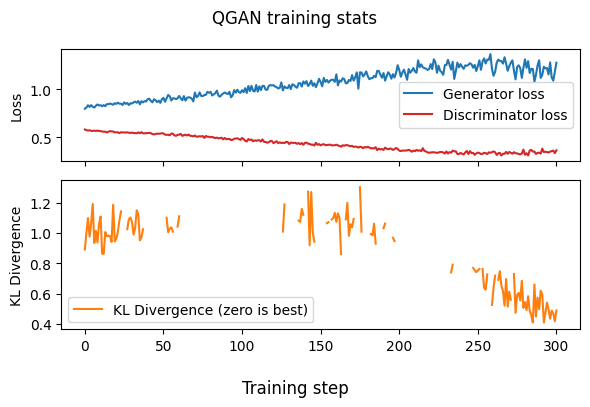

In [238]:
draw_results = 1
if draw_results:
        def prepare_loss_data(l): # For when C_STEPS > 1, implemented for creating less jobs in real hardware
                ax = [0]
                data =  [l[0]]
                for i in range(1, len(l)):
                        if l[i] != l[i - 1]:
                                ax.append(i)
                                data.append(l[i])
                return ax, data
        
        # Load saved data
        data_file, current_epoch, gloss, dloss, kl_div, init_gen_params, best_gen_state = load_progress()

        gloss_ax, gloss_data = prepare_loss_data(gloss)
        dloss_ax, dloss_data = prepare_loss_data(dloss)

        fig, (loss, kl) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [0.75, 1]}, figsize=(6,4))
        fig.suptitle('QGAN training stats')
        fig.supxlabel('Training step')
        loss.plot(gloss_ax, gloss_data, label="Generator loss")
        loss.plot(dloss_ax, dloss_data, label="Discriminator loss", color="C3")
        loss.legend()
        loss.set(ylabel='Loss')
        kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)", color="C1")
        kl.set(ylabel='KL Divergence')
        kl.legend()
        fig.tight_layout()

{0: 0.138671875, 1: 0.0751953125, 2: 0.005859375, 3: 0.0947265625, 4: 0.0029296875, 5: 0.0078125, 6: 0.0244140625, 7: 0.0048828125, 8: 0.0, 9: 0.0107421875, 10: 0.0078125, 11: 0.001953125, 12: 0.2099609375, 13: 0.240234375, 14: 0.119140625, 15: 0.0556640625}


TypeError: '<' not supported between instances of 'str' and 'int'

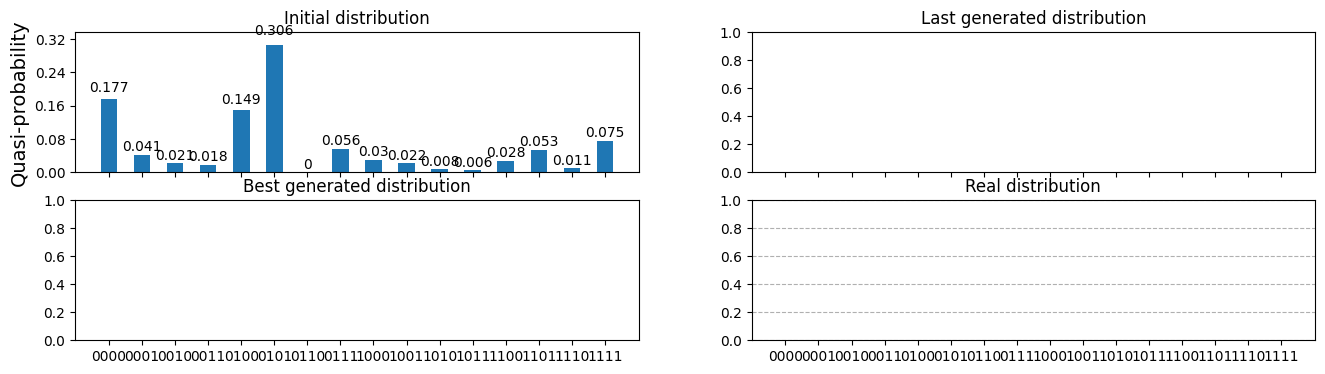

In [241]:
# Create test circuit with new parameters
draw_results = 1
if draw_results:
    dict1 = Statevector(generator_circuit.assign_parameters(init_gen_params)).probabilities_dict()
    dict2 = list_to_dict(generator(torch.tensor([])).tolist())
    print(dict2)
    best_generator = generate_generator(generator_circuit, sampler, gradient)
    best_generator.load_state_dict(best_gen_state)
    dict3 = list_to_dict(best_generator(torch.tensor([])).tolist())
    dict4 = real_prob_dict

    prepare_dicts([dict1, dict2, dict3, dict4])

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=False, sharex=True, figsize=(16,4))
    ax1.set_title("Initial distribution")
    ax2.set_title("Last generated distribution")
    ax3.set_title("Best generated distribution")
    ax4.set_title("Real distribution")
    plot_histogram(dict1, ax=ax1)
    plot_histogram(dict2, ax=ax2)
    plot_histogram(dict3, ax=ax3)
    plot_histogram(dict4, ax=ax4)
    #fig.tight_layout()